# Создание рекомендательной системы

## Цели работы:

Необходимо реализовать алгоритм построения рекомендательной системы на основе истории оценок пользователей для товаров.

Для оценки качества модели будет использоваться метрика RocAuc. Это одна из самых популярных метрик в задачах бинарной классификации поскольку мы хотим предсказывать, понравится ли товар пользователю или нет.

В качестве алгоритма для построения рекомендаций после ряда экспериментов был выбран LightFM.

Ссылка на учебное соревнование SkillFactory: https://www.kaggle.com/c/recommendationsv4/

# 1.Импорт библиотек и подготовка данных

In [1]:
#Импортируем необходимые библиотеки
from datetime import datetime

import pandas as pd

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

In [3]:
train = pd.read_csv('data/train.csv', low_memory=False)
test = pd.read_csv('data/test.csv', low_memory=False)
submission = pd.read_csv('data/sample_submission.csv')

Посмотрим на данные в тренировочном датасете:

In [4]:
display(train.head(5))
train.info()

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


overall - рейтинг, который поставил пользователь

verified - был ли отзыв верифицирован

reviewTime - когда был отзыв написан

reviewerName - имя пользователя

reviewText - текст отзыва

summary - сжатый отзыв

vote - количество голосований за отзыв

style - метаданные

image - изображение продукта

userid - id пользователя

itemid - id товара

id - id для предсказания

In [5]:
# посмотрим на пропуски и типы данных:
def param_data(data): 
    param = pd.DataFrame({
              'dtypes': data.dtypes.values,
              'nunique': data.nunique().values,
              'isna': data.isna().sum().values,
              }, 
             index = data.loc[0].index)
    return param

pd.concat([param_data(train), param_data(test)], 
          axis=1, 
          keys = [f'Train  {train.shape}', f' Test  {test.shape}'],  
          sort=False)

Train  (857895, 14)                      Test  (285965, 11)  \
                            dtypes   nunique      isna              dtypes   
overall                    float64       5.0       0.0                 NaN   
verified                      bool       2.0       0.0                bool   
reviewTime                  object    4580.0       0.0              object   
asin                        object   41302.0       0.0              object   
reviewerName                object  101207.0     176.0              object   
reviewText                  object  686739.0     279.0                 NaN   
summary                     object  411451.0     170.0                 NaN   
unixReviewTime               int64    4580.0       0.0               int64   
vote                        object     311.0  739155.0              object   
style                       object   25892.0  413489.0              object   
image                       object    6636.0  850753.0              object   
userid                       int64  127448.0       0.0               int64   
itemid                       int64   41302.0       0.0               int64   
rating                     float64       2.0       0.0                 NaN   
Id                             NaN       NaN       NaN               int64   

                                    
                 nunique      isna  
overall              NaN       NaN  
verified             2.0       0.0  
reviewTime        4349.0       0.0  
asin             37876.0       0.0  
reviewerName     86815.0      47.0  
reviewText           NaN       NaN  
summary              NaN       NaN  
unixReviewTime    4349.0       0.0  
vote               198.0  246503.0  
style            18904.0  138285.0  
image             2306.0  283597.0  
userid          109357.0       0.0  
itemid           37876.0       0.0  
rating               NaN       NaN  
Id              285965.0       0.0

Есть немного пропусков в поле reviewerName. Cкорее всего, это никак не должно влиять на остальные данные, поэтому просто удалим этот столбец и будем идентифицировать пользователья только по userid. Дополнительно убедимся в этом, посмотрев на распределениe первоначальной оценки overall и разброс времени оставления отзывов для клиентов с наличием reviewerName и его отсутствием.

In [4]:
#удалим дубликаты в тренировочной выборке, после удаления вместо 857895 строк остается 826895
train.drop_duplicates(keep='first',inplace=True)
print('Размер тренировочной выборки:', train.shape)

Размер тренировочной выборки: (826895, 14)


In [7]:
#удалим дубликаты в тестовой выборке, как мы видим, дубликатов в тестовой выборке нет
test.drop_duplicates(keep='first',inplace=True)
print('Размер тестовой выборки:', test.shape)

Размер тестовой выборки: (285965, 11)


Рассмотрим каждый признак более детально:

In [8]:
def column_stats(column):
    
    if column.dtype == 'int64' or column.dtype == 'float64':
        
        display(column.describe())
        
        plt.figure(figsize=(8,5))
        column.hist(bins=column.nunique()) 
        
        display(f'Данный признак содержит {column.isnull().sum()} пропусков')
    else:
        display(column.describe())
        display(column.value_counts())      
        display(f'Данный признак содержит {column.isnull().sum()} пропусков')

# overall 

count    826895.000000
mean          4.440251
std           1.065334
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

'Данный признак содержит 0 пропусков'

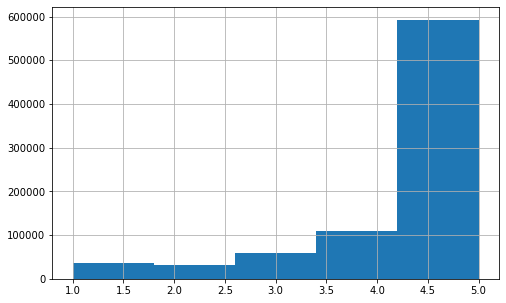

In [9]:
column_stats(train['overall'])

In [10]:
train.groupby(['overall']).rating.mean()

overall
1.0    0.0
2.0    0.0
3.0    0.0
4.0    1.0
5.0    1.0
Name: rating, dtype: float64

По зависимости столбцов overall и rating можно сделать вывод, что пользователю рекомедуются товары с оценкой 4 и выше, о чем и говорится в нашем задании

# verified

In [11]:
column_stats(train['verified'])

count     826895
unique         2
top         True
freq      718164
Name: verified, dtype: object

True     718164
False    108731
Name: verified, dtype: int64

'Данный признак содержит 0 пропусков'

In [12]:
train.groupby(['verified']).rating.mean()

verified
False    0.782178
True     0.858530
Name: rating, dtype: float64

От верификации отзыва рейтинг не зависит.

# reviewTime

In [13]:
column_stats(train['reviewTime'])

count         826895
unique          4580
top       03 1, 2016
freq             909
Name: reviewTime, dtype: object

03 1, 2016     909
07 14, 2016    858
06 3, 2015     769
01 20, 2016    764
02 20, 2016    753
              ... 
04 29, 2007      1
02 11, 2005      1
11 25, 2006      1
10 25, 2005      1
10 30, 2005      1
Name: reviewTime, Length: 4580, dtype: int64

'Данный признак содержит 0 пропусков'

In [14]:
train.groupby(['reviewTime']).rating.mean()

reviewTime
01 1, 2007    1.000000
01 1, 2008    0.666667
01 1, 2009    0.846154
01 1, 2010    0.545455
01 1, 2011    0.857143
                ...   
12 9, 2013    0.789668
12 9, 2014    0.893939
12 9, 2015    0.875847
12 9, 2016    0.848797
12 9, 2017    0.813953
Name: rating, Length: 4580, dtype: float64

Переведем признак в datetime и отедльно с ним поработаем.

# asin

In [15]:
column_stats(train['asin'])

count         826895
unique         41302
top       B00BUKL666
freq            5430
Name: asin, dtype: object

B00BUKL666    5430
B00D3M2QP4    4733
B008QMX2SG    4611
B00R7PWK7W    2449
B000F4DKAI    2166
              ... 
B0017I1QAC       1
B0012TCW1S       1
B00122CN8C       1
B00I6OFQL0       1
B01ATVALDA       1
Name: asin, Length: 41302, dtype: int64

'Данный признак содержит 0 пропусков'

asin - кодировка товара, на его основании создаются itedid, он нам будет нужен для формирования таблицы item_features

In [16]:
train.groupby(['asin']).itemid.mean()

asin
4639725043        1
4639725183        0
5463213682        2
9742356831        3
B00004S1C5        4
              ...  
B01HJ2OFYI    38319
B01HJ4FWGG    38320
B01HJ7QPKU    38321
B01HJCUNOO    38322
B01HJF6FRA    38323
Name: itemid, Length: 41302, dtype: int64

# reviewerName

In [17]:
column_stats(train['reviewerName'])

count              826731
unique             101207
top       Amazon Customer
freq                30612
Name: reviewerName, dtype: object

Amazon Customer     30612
Kindle Customer      6012
Linda                 713
John                  695
David                 597
                    ...  
Ricky W.                1
Trinirose               1
Lisa C. B. Eaton        1
PoodleMommy             1
lvschultz2              1
Name: reviewerName, Length: 101207, dtype: int64

'Данный признак содержит 164 пропусков'

Посольку многие имена вымышленные (Amazon Customer, Kindle Customer), и по логике вещей, имя не может влиять на предпочтения потсребителя. Посомтрим на распределение оценок среди пользователей указавших и не указавших имя:

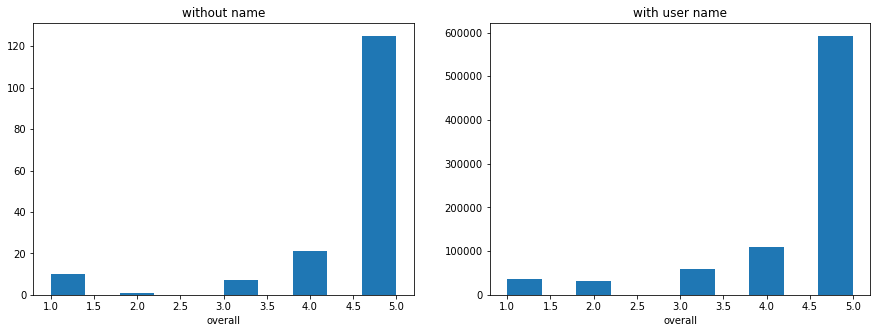

In [18]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
axes[0].set_title('without name')
axes[0].set_xlabel('overall')
axes[1].set_title('with user name')
axes[1].set_xlabel('overall')
axes[0].hist(train[train.reviewerName.isna() == True].overall)
axes[1].hist(train[train.reviewerName.isna() == False].overall)

plt.show()

Как мы видим, пропорции оценок очень похожи, поэтому будем считать, что укзание имени не влияет на рейтинг. Столбец можно удалить, в дальнейшем будем использовать userid для идентификации пользвателя.

# reviewText 

In [19]:
column_stats(train['reviewText'])

count     826621
unique    686739
top         good
freq        3019
Name: reviewText, dtype: object

good                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         3019
great                                                                                                                                                                                                                                                                                 

'Данный признак содержит 274 пропусков'

In [20]:
train.groupby(['reviewText']).rating.mean()

reviewText
\n\n\n\n\n\nI                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          1.0
\n

# summary

In [21]:
column_stats(train['summary'])

count         826729
unique        411451
top       Five Stars
freq          167416
Name: summary, dtype: object

Five Stars                                                  167416
Four Stars                                                   26010
Three Stars                                                  11682
One Star                                                      5206
Two Stars                                                     4824
                                                             ...  
but otherwise liked.                                             1
I've bought a lot of Turkish apricots over the years ...         1
Rancid flavor, very disappointed.                                1
Delicious flavors, smooth, great price                           1
Slightly stale but tasty                                         1
Name: summary, Length: 411451, dtype: int64

'Данный признак содержит 166 пропусков'

<AxesSubplot:>

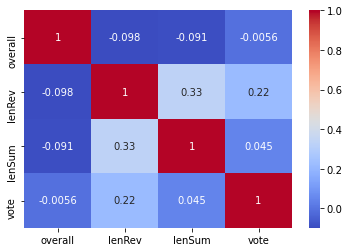

In [22]:
# определим длину отзыва в символах и посмотрим, влияет ли на оценку
train['lenRev'] = train['reviewText'].apply(lambda x: len(str(x)))
train['lenSum'] = train['summary'].apply(lambda x: len(str(x)))
train['vote'] = train.vote.apply(lambda x: str(x).replace(',',''))
train['vote'] = train['vote'].fillna('0').astype('float64')
sns.heatmap(train[['overall', 'lenRev', 'lenSum', 'vote']].corr(), cmap='coolwarm', annot=True)
# связи практически нет с целевой переменной, эти столбцы не нужны
#   также нет связи между оценкой и количеством голосований за отзыв - очень слабая

# unixReviewTime

count    8.268950e+05
mean     1.442305e+09
std      5.961629e+07
min      9.657792e+08
25%      1.412467e+09
50%      1.449706e+09
75%      1.485389e+09
max      1.538438e+09
Name: unixReviewTime, dtype: float64

'Данный признак содержит 0 пропусков'

1456790400    909
1468454400    858
1433289600    769
1453248000    764
1455926400    753
             ... 
1105142400      1
1131062400      1
1161993600      1
1142467200      1
1177113600      1
Name: unixReviewTime, Length: 4580, dtype: int64

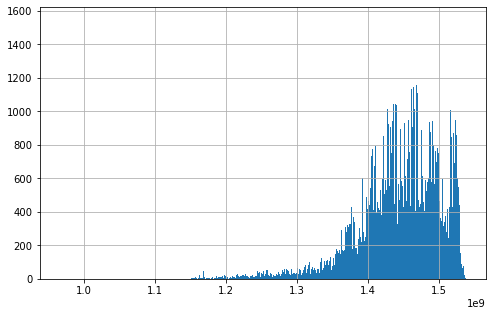

In [23]:
column_stats(train['unixReviewTime'])
train['unixReviewTime'].value_counts()

# vote

count    113951.000000
mean          6.695913
std          20.424569
min           2.000000
25%           2.000000
50%           3.000000
75%           6.000000
max        1626.000000
Name: vote, dtype: float64

'Данный признак содержит 712944 пропусков'

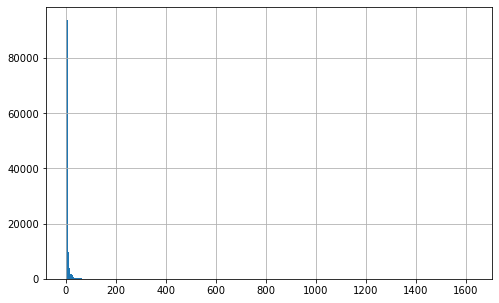

In [24]:
column_stats(train['vote'])

Будем считать, что если значение в столбце vote не указано, значит за отзыв никто не голосовал, поэтому заменим пропуски на 0.

In [25]:
train['vote'] = train.vote.apply(lambda x: str(x).replace(',',''))
train['vote'] = train['vote'].fillna('0').astype('float64')

# style

In [26]:
column_stats(train['style'])

count                      428197
unique                      25892
top       {'Size:': ' Pack of 1'}
freq                         4549
Name: style, dtype: object

{'Size:': ' Pack of 1'}                                                  4549
{'Package Quantity:': ' 1'}                                              4461
{'Package Type:': ' Standard Packaging'}                                 3860
{'Size:': ' 1 Pack'}                                                     3688
{'Size:': ' 24 Count'}                                                   3615
                                                                         ... 
{'Size:': ' 2', 'Flavor:': ' Milk Chocolate'}                               1
{'Size:': ' 1.7-Ounce Bars (Pack of 24)', 'Flavor:': ' Apricot Goji'}       1
{'Flavor:': ' Berry Muffin'}                                                1
{'Flavor:': ' Lemon Taxi'}                                                  1
{'Style Name:': ' Parmesan and Garlic'}                                     1
Name: style, Length: 25892, dtype: int64

'Данный признак содержит 398698 пропусков'

# image

In [27]:
column_stats(train['image'])

count                                                  6979
unique                                                 6636
top       ['https://images-na.ssl-images-amazon.com/imag...
freq                                                      6
Name: image, dtype: object

['https://images-na.ssl-images-amazon.com/images/I/712zJIOTV5L._SY88.jpg']                                                                                                                                                                                                                                                                                                                                                                                      6
['https://images-na.ssl-images-amazon.com/images/I/71+Z1TA3eyL._SY88.jpg']                                                                                                                                                                                                                                                                                                                                                                                      6
['https://images-na.ssl-images-amazon.com/images/I/81kah7EsJtL._SY88.jpg', 'https://images-na.ssl-im

'Данный признак содержит 819916 пропусков'

Пропусков более 80%, это просто ссылка на картинку, поэтому этот признак можно смело удалять.

userid, itemid и rating пропусков не имеют

# rating

count    826895.000000
mean          0.848490
std           0.358546
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: rating, dtype: float64

'Данный признак содержит 0 пропусков'

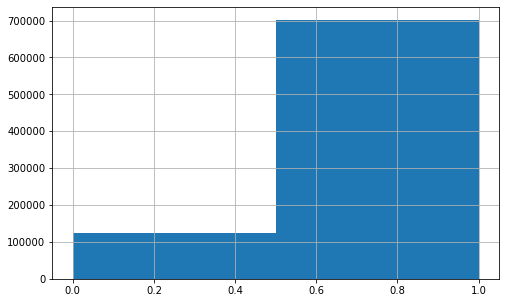

In [28]:
column_stats(train['rating'])

In [29]:
train.groupby(['itemid', 'userid']).rating.mean()

itemid  userid
0       1         1.0
        3         1.0
        4         1.0
        6         1.0
        8         1.0
                 ... 
41317   126153    0.0
41318   70691     1.0
        88460     1.0
41319   35230     1.0
        127461    1.0
Name: rating, Length: 812698, dtype: float64

# Посмотрим на данные в тестовом датасете:

In [30]:
display(test.head(5))
test.info()

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4


<class 'pandas.core.frame.DataFrame'>
Int64Index: 285965 entries, 0 to 285964
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        285965 non-null  bool  
 1   reviewTime      285965 non-null  object
 2   asin            285965 non-null  object
 3   reviewerName    285918 non-null  object
 4   unixReviewTime  285965 non-null  int64 
 5   vote            39462 non-null   object
 6   style           147680 non-null  object
 7   image           2368 non-null    object
 8   userid          285965 non-null  int64 
 9   itemid          285965 non-null  int64 
 10  Id              285965 non-null  int64 
dtypes: bool(1), int64(4), object(6)
memory usage: 24.3+ MB


# verified

In [31]:
column_stats(test['verified'])

count     285965
unique         2
top         True
freq      248604
Name: verified, dtype: object

True     248604
False     37361
Name: verified, dtype: int64

'Данный признак содержит 0 пропусков'

In [32]:
column_stats(test['reviewTime'])

count         285965
unique          4349
top       03 1, 2016
freq             316
Name: reviewTime, dtype: object

03 1, 2016     316
01 20, 2016    301
06 3, 2015     278
07 14, 2016    271
04 29, 2015    265
              ... 
06 3, 2007       1
01 29, 2007      1
10 25, 2006      1
10 16, 2006      1
08 26, 2006      1
Name: reviewTime, Length: 4349, dtype: int64

'Данный признак содержит 0 пропусков'

In [33]:
column_stats(test['asin'])

count         285965
unique         37876
top       B00BUKL666
freq            1896
Name: asin, dtype: object

B00BUKL666    1896
B008QMX2SG    1574
B00D3M2QP4    1488
B00R7PWK7W     840
B0001LO3FG     796
              ... 
B005TH72FK       1
B0196ORRRO       1
B01G5MRGDA       1
B00BTI8446       1
B00CJBR37G       1
Name: asin, Length: 37876, dtype: int64

'Данный признак содержит 0 пропусков'

In [34]:
column_stats(test['reviewerName'])

count              285918
unique              86815
top       Amazon Customer
freq                10642
Name: reviewerName, dtype: object

Amazon Customer    10642
Kindle Customer     2060
Linda                254
John                 225
Michael              195
                   ...  
Mary Hammond           1
legf7                  1
Niece                  1
MLM Luy                1
D. S. Ziegler          1
Name: reviewerName, Length: 86815, dtype: int64

'Данный признак содержит 47 пропусков'

count    2.859650e+05
mean     1.441818e+09
std      5.955711e+07
min      1.023322e+09
25%      1.411949e+09
50%      1.449101e+09
75%      1.484870e+09
max      1.538438e+09
Name: unixReviewTime, dtype: float64

'Данный признак содержит 0 пропусков'

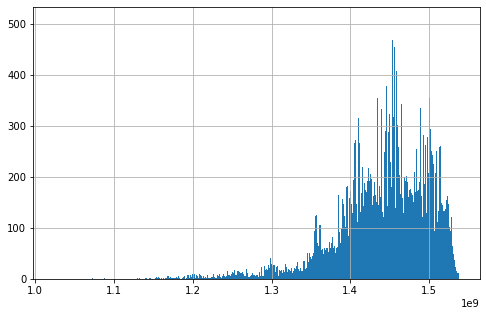

In [35]:
column_stats(test['unixReviewTime'])

count    2.859650e+05
mean     1.441818e+09
std      5.955711e+07
min      1.023322e+09
25%      1.411949e+09
50%      1.449101e+09
75%      1.484870e+09
max      1.538438e+09
Name: unixReviewTime, dtype: float64

'Данный признак содержит 0 пропусков'

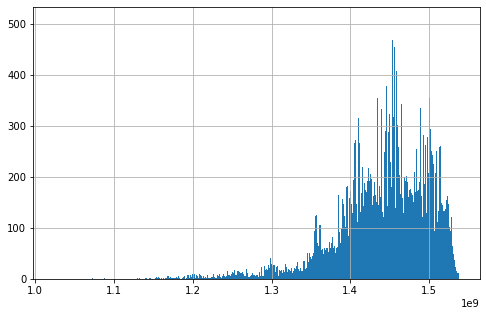

In [36]:
column_stats(test['unixReviewTime'])

In [37]:
column_stats(test['vote'])

count     39462
unique      198
top           2
freq      14805
Name: vote, dtype: object

2        14805
3         7404
4         4128
5         2719
6         2027
7         1341
8         1043
9          818
10         626
11         525
12         414
13         350
14         285
15         250
16         234
17         201
20         161
18         155
19         148
21         119
22         117
24         101
23          84
25          72
27          71
26          68
28          67
30          62
29          58
34          47
37          38
31          38
32          37
33          34
45          32
35          32
36          30
40          29
42          29
46          25
38          25
43          24
39          24
44          20
41          20
50          17
57          15
49          15
53          14
47          14
66          14
63          13
51          13
52          13
64          13
59          12
48          11
76          11
60          10
61          10
54          10
75          10
58           9
56           9
55           9
85           9
92        

'Данный признак содержит 246503 пропусков'

In [38]:
column_stats(test['style'])

count                      147680
unique                      18904
top       {'Size:': ' Pack of 1'}
freq                         1826
Name: style, dtype: object

{'Size:': ' Pack of 1'}                                                       1826
{'Package Quantity:': ' 1'}                                                   1576
{'Package Type:': ' Standard Packaging'}                                      1326
{'Size:': ' 1 Pack'}                                                          1312
{'Size:': ' 24 Count'}                                                        1265
                                                                              ... 
{'Size:': ' 14.1 Ounce (Pack of 12)', 'Flavor:': ' Chocolatey Strawberry'}       1
{'Size:': ' 150 Pods', 'Flavor:': ' Miscela Oro'}                                1
{'Style:': ' Without vase'}                                                      1
{'Size:': ' 32-oz (12 Pack)', 'Flavor:': ' Chocolate'}                           1
{'Size:': ' 30 oz', 'Style:': ' Lime'}                                           1
Name: style, Length: 18904, dtype: int64

'Данный признак содержит 138285 пропусков'

In [39]:
column_stats(test['image'])

count                                                  2368
unique                                                 2306
top       ['https://images-na.ssl-images-amazon.com/imag...
freq                                                      3
Name: image, dtype: object

['https://images-na.ssl-images-amazon.com/images/I/71anmB-jMDL._SY88.jpg', 'https://images-na.ssl-images-amazon.com/images/I/71JlDG4cflL._SY88.jpg']                                                                                                                                                                                                                                  3
['https://images-na.ssl-images-amazon.com/images/I/61LU9eMwKhL._SY88.jpg', 'https://images-na.ssl-images-amazon.com/images/I/61b2V9e-KOL._SY88.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51L6pfOqXWL._SY88.jpg', 'https://images-na.ssl-images-amazon.com/images/I/51-LgT73vzL._SY88.jpg']                                                                              3
['https://images-na.ssl-images-amazon.com/images/I/51vSf7KEj1L._SY88.jpg']                                                                                                                                                                              

'Данный признак содержит 283597 пропусков'

Признак содержит большое количество пропусков, не несет большого влияния на целевую переменную, поэтому его можно удалить.

# Посмотрим на мета-словарь для продуктов:

In [5]:
import json
meta = []
with open('meta_Grocery_and_Gourmet_Food.json', 'r') as in_file:
    for line in in_file:
        meta.append(json.loads(line))



In [6]:
df = pd.DataFrame(meta)
df.head()

,category,description,title,brand,rank,also_view,main_cat,price,asin,also_buy,image,date,feature,details,similar_item,tech1,fit
0,"[Grocery & Gourmet Food, Dairy, Cheese & Eggs,...","[BEEMSTER GOUDA CHEESE AGED 18/24 MONTHS, Stat...",Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,"165,181inGroceryGourmetFood(","[B0000D9MYM, B0000D9MYL, B00ADHIGBA, B00H9OX59...",Grocery,$41.91,0681727810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Grocery & Gourmet Food, Cooking & Baking, Sug...","[Shipped from UK, please allow 10 to 21 busine...",Trim Healthy Mama Xylitol,NaN,"315,867inGroceryGourmetFood(",NaN,Grocery,NaN,0853347867,"[B01898YHXK, B01BCM6LAC, B00Q4OL47O, B00Q4OL5Q...",[https://images-na.ssl-images-amazon.com/image...,NaN,NaN,NaN,NaN,NaN,NaN
2,"[Grocery & Gourmet Food, Cooking & Baking, Fro...",[Jazz up your cakes with a sparkling monogram ...,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#669,941 in Kitchen & Dining (See Top 100 in ...",[B07DXN65TF],Amazon Home,$29.95,1888861118,NaN,NaN,"September 21, 2010",NaN,NaN,NaN,NaN,NaN
3,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[Large Letter - Height 4.75""]",Letter H - Swarovski Crystal Monogram Wedding ...,Other,">#832,581 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$11.45,1888861517,NaN,NaN,"September 11, 2011","[Large Letter - Height 4.75""]",NaN,NaN,NaN,NaN
4,"[Grocery & Gourmet Food, Cooking & Baking, Fro...","[4.75""]",Letter S - Swarovski Crystal Monogram Wedding ...,Unik Occasions,">#590,999 in Kitchen & Dining (See Top 100 in ...",NaN,Amazon Home,$15.00,1888861614,NaN,NaN,"September 11, 2011","[4.75"" height]",NaN,NaN,NaN,NaN


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   category      287209 non-null  object
 1   description   251802 non-null  object
 2   title         287205 non-null  object
 3   brand         275787 non-null  object
 4   rank          275494 non-null  object
 5   also_view     121012 non-null  object
 6   main_cat      285716 non-null  object
 7   price         132136 non-null  object
 8   asin          287209 non-null  object
 9   also_buy      83332 non-null   object
 10  image         150214 non-null  object
 11  date          9663 non-null    object
 12  feature       16374 non-null   object
 13  details       273323 non-null  object
 14  similar_item  256 non-null     object
 15  tech1         744 non-null     object
 16  fit           4 non-null       object
dtypes: object(17)
memory usage: 37.3+ MB


In [8]:
#Создадим фичи для продуктов
# сосчитаем, сколько всего отзывов на товар было оставлено
df['count_rev'] = train[['itemid', 'unixReviewTime']].groupby('itemid').count() 
df['asin'] = train[['itemid', 'asin']].groupby('itemid').first()

In [9]:
df['item_id'] = df.index

In [10]:
# добавим среднюю оценку для каждого товара
df['overall_mean'] = train[['itemid', 'overall']].groupby('itemid').mean()

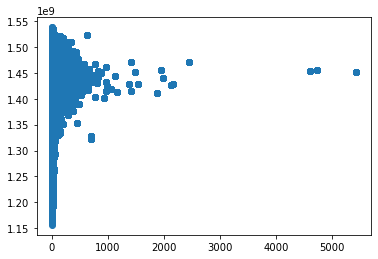

In [47]:
# Посмотрим на зависимость средней оценки от количетсва отзывов
plt.scatter(df.count_rev, df.overall_mean)

По нашему графику видно, что для часто покупаемых товаров характерны высокие оценки

In [11]:
# оставим категорию самую последнюю
df['category'] = df['category'].apply(lambda x: x[-1])

In [12]:
#присваиваем каждой категории свой id
set_category = set(df.category.unique())
print(f'всего категорий: {len(set_category)}')
mapper = dict(zip(set_category, range(len(set_category))))
df['cat_id'] = df['category'].apply(lambda x: mapper[x])

всего категорий: 1175


In [13]:
#Заменяем пропуски
df['main_cat'].fillna('Other', inplace = True)
df['brand'].fillna('Other', inplace = True)
df['price'].fillna('NA', inplace = True)

In [14]:
items = df[['item_id','category', 'title', 'brand', 'main_cat', 'price', 'asin', 'count_rev', 'overall_mean','cat_id']]
items.head()


,item_id,category,title,brand,main_cat,price,asin,count_rev,overall_mean,cat_id
0,0,Gouda,Beemster Gouda - Aged 18/24 Months - App. 1.5 Lbs,Ariola Imports,Grocery,$41.91,4639725183,8.0,4.875000,736
1,1,Xylitol,Trim Healthy Mama Xylitol,Other,Grocery,NA,4639725043,21.0,4.190476,619
2,2,Cake Toppers,Letter C - Swarovski Crystal Monogram Wedding ...,Unik Occasions,Amazon Home,$29.95,5463213682,7.0,4.857143,962
3,3,Cake Toppers,Letter H - Swarovski Crystal Monogram Wedding ...,Other,Amazon Home,$11.45,9742356831,74.0,4.581081,962
4,4,Cake Toppers,Letter S - Swarovski Crystal Monogram Wedding ...,Unik Occasions,Amazon Home,$15.00,B00004S1C5,10.0,4.400000,962


In [15]:
items=items.drop_duplicates(keep='first') #удалим дубликаты из датасета с описанием товаров

In [16]:
items = items.dropna(axis=0) # удалим строки с пропусками

In [17]:
items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41301 entries, 0 to 41319
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       41301 non-null  int64  
 1   category      41301 non-null  object 
 2   title         41301 non-null  object 
 3   brand         41301 non-null  object 
 4   main_cat      41301 non-null  object 
 5   price         41301 non-null  object 
 6   asin          41301 non-null  object 
 7   count_rev     41301 non-null  float64
 8   overall_mean  41301 non-null  float64
 9   cat_id        41301 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 3.5+ MB


In [18]:
# запишем получившийся датафрейм в файл
items.to_csv('data/items1.csv')

# 2. Обработка данных


In [56]:
# удалим колонку reviewerName из тренировочного датасета
train.drop('reviewerName', axis = 1, inplace = True)

# переведем дату в формат datetime. 
# Дублирующий столбец unixReviwTime удалать не будем
train.reviewTime = pd.to_datetime(train.reviewTime)

# удалим дублирующиеся отзывы, так как при построении разреженной матрицы значения рейтингов складываются. 
# Это не отражает реальную ситуацию
train.drop_duplicates(subset=['userid', 'itemid'], keep='last', inplace=True)

# удалим столбцы style, image, summary и reviewText
train.drop(['style', 'image','summary', 'reviewText'], axis=1, inplace=True)

train

,overall,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,userid,itemid,rating,lenRev,lenSum
0,5.0,True,2016-10-04,B01CPNIEQG,Heather,1475539200,NaN,102179,37138,1.0,231,31
1,5.0,True,2016-03-01,B006F63M8U,Linda Odom,1456790400,NaN,3625,17322,1.0,81,39
2,5.0,True,2016-06-26,B00112O8NG,DesertBlossom,1466899200,28.0,39495,5600,1.0,1541,56
3,5.0,True,2013-09-05,B00MRAQUM8,Connie L. Reaves,1378339200,NaN,72854,30249,1.0,252,6
4,5.0,True,2016-09-14,B000R7RN0G,Mike P.,1473811200,NaN,74859,4349,1.0,119,43
...,...,...,...,...,...,...,...,...,...,...,...,...
857889,5.0,True,2016-11-04,B008QMX2SG,B. M. C,1478217600,NaN,70292,24556,1.0,20,7
857890,5.0,True,2013-04-02,B000H7ELTW,chezlouise,1364860800,NaN,59433,2566,1.0,284,37
857892,4.0,False,2016-09-21,B000LKX6R8,bamboo grove,1474416000,NaN,88,3251,1.0,183,31
857893,4.0,True,2015-11-01,B00BUKL666,Speedway91,1446336000,NaN,41540,22208,1.0,182,15


In [57]:
# запишем получившийся датафрейм в файл
train.to_csv('train_pr1.csv')

In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 812698 entries, 0 to 857894
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   overall         812698 non-null  float64       
 1   verified        812698 non-null  bool          
 2   reviewTime      812698 non-null  datetime64[ns]
 3   asin            812698 non-null  object        
 4   reviewerName    812534 non-null  object        
 5   unixReviewTime  812698 non-null  int64         
 6   vote            111797 non-null  float64       
 7   userid          812698 non-null  int64         
 8   itemid          812698 non-null  int64         
 9   rating          812698 non-null  float64       
 10  lenRev          812698 non-null  int64         
 11  lenSum          812698 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 75.2+ MB


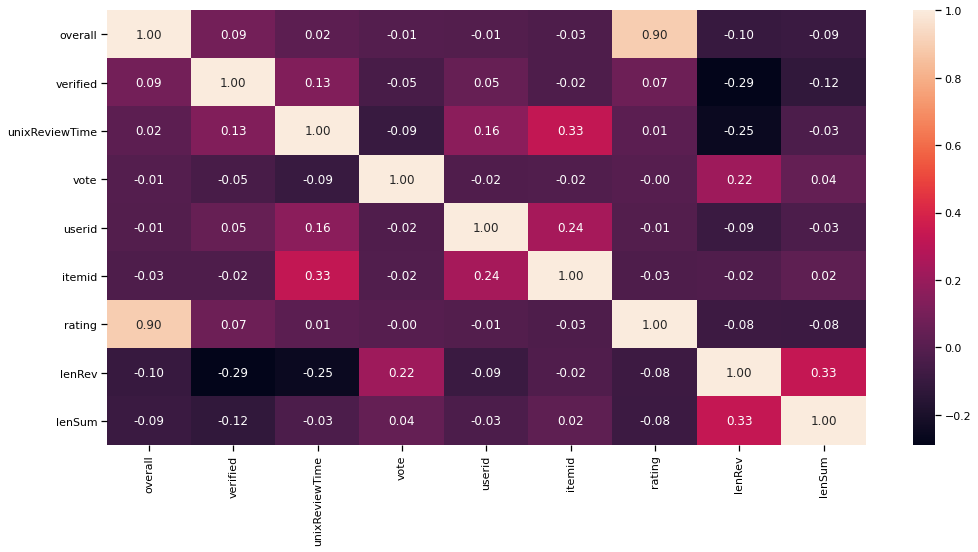

In [59]:
#Посмотрим на корреляции в трейне
corr=train.corr()

sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(17,8))
a = sns.heatmap(corr, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=90)
roty = a.set_yticklabels(a.get_yticklabels(), rotation=0)

Анализ показал, корреляции между независимыми признаками достаточно слабы, поэтому для дальнейшего обучения ограничимся только несколькими из них для демонстрации работы алгоритма с матрицей item-features.

Перейдем к построению модели.